### Assignment 11: LLM Inference for Monetary Policy Classification and Market Analysis
---
Name: Shiqi Hu

GTID: 904061372

#### Step 0: Background Research
---
**Define and explain zero-shot inference in the context of language models.**

In the context of language models, zero-shot inference is to let the language model generate response according to a task given by the prompt based on its previous knowledge and general understanding of language, without having been explicitly trained on examples of that task in the prompt.

**Summarize the paper in few sentences in your own words. (Use of ChatGPT not allowed for this part)**

This paper aims to evaluate the capabilities of ChatGPT for financial NLP tasks. The authors benchmark the zero-shot performance of ChatGPT-3.5-Turbo, Dolly-V2-12B, and H2O-12B, comparing them to a fine-tuned RoBERTa model across four financial NLP tasks. Their experiments reveal that, while fine-tuned PLMs generally outperform zero-shot ChatGPT on the hawkish-dovish sequence classification task, ChatGPT still demonstrates impressive performance. In financial sentiment analysis, a notable performance gap is observed between fine-tuned PLMs and ChatGPT, especially when the dataset is not publicly available. For financial numerical claim detection, they find that the time required to label a single sample with generative LLMs is significantly higher. Overall, this paper highlights the potential and limitations of ChatGPT, emphasizing the trade-offs between performance, availability of labeled data, and labeling efficiency.

#### Step 1: Zero-Shot and Few-Shot Inference with Llama-3-70b-Chat Model
---


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import io
import re
import os
import json
import pandas_datareader as pdr
from datetime import datetime

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
# from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

import together
import requests
from tqdm import tqdm
import time

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset as HFDataset
import torch
from sklearn.model_selection import train_test_split

**1.1 Zero-Shot: Use the model directly on the FOMC sentences without any prior examples.**

In [61]:
api_key = os.getenv("TOGETHER_API_KEY")
headers = {
    'Authorization': f'Bearer {api_key}',
    'Content-Type': 'application/json'
}
url = "https://api.together.ai/v1/completions"
model_id = "meta-llama/Llama-3-70b-chat-hf"

test_df = pd.read_excel('lab-manual-mm-test-5768.xlsx')
# test_df_5row = test_df.head(5)
zero_shot_preds=[]
zero_shot_start = time.time()  # Start timing

# Process each sentence
for index, sentence in tqdm(enumerate(test_df['sentence']), total=test_df.shape[0]): 
    prompt = f"""Discard all the previous instructions. Behave like you are an expert sentence classifier 
                who also knows well about financial terms, especially federal monetary policy. 
                Classify the following sentence from FOMC into 'HAWKISH', 'DOVISH', or 'NEUTRAL' class. 
                Label 'HAWKISH' if it is corresponding to tightening of the monetary policy,
                'DOVISH' if it is corresponding to easing of the monetary policy, or 'NEUTRAL' if the
                stance is neutral. Explanation is not needed.

Statement: {sentence}

Classification:"""

    data = json.dumps({
        "model": model_id,
        "prompt": prompt,
        "max_tokens": 100,
        "temperature": 0
    })

    response = requests.post(url, headers=headers, data=data)
    if response.status_code == 200:
        response_text = response.json()['choices'][0]['text'].strip().upper()
        # print(f"Sentence: {sentence}\nResponse: {response_text}\n")  # Printing each result
        if 'HAWKISH' in response_text:
            pred = 1    # HAWKISH
        elif 'DOVISH' in response_text:
            pred = 0    # DOVISH
        elif 'NEUTRAL' in response_text:
            pred = 2    # NEUTRAL
        else:
            pred = 2  # Default to NEUTRAL if unclear
    else:
        print(f"API call failed: {response.status_code} - {response.text}")
        pred = 2  # Default to NEUTRAL in case of error

    zero_shot_preds.append(pred)
    time.sleep(1)   # Pause to avoid hitting rate limits

test_df['zero_shot_prediction'] = zero_shot_preds

zero_shot_time = time.time() - zero_shot_start
print(f"\nZero-shot inference time: {zero_shot_time:.2f} seconds")


100%|██████████| 214/214 [06:02<00:00,  1.70s/it]


Zero-shot inference time: 362.80 seconds


**1.2 Few-Shot: Experiment with 3-5 example sentences. Analyze the number and type of examples that yield the most accurate results, and explain your selection process.**

**Selected Few-Shot Examples After Tried Different Sentence Combination:**
- Measures of inflation compensation based on TIPS fell in response to the soft reading on core inflation in the November CPI release but subsequently moved up against the backdrop of an improving global growth outlook, higher commodity prices, depreciation of the dollar, and the stronger-than-expected reading on core inflation in the December CPI release. (**1: Hawkish**)
- In their discussion of the balance-of-risks sentence in the press statement to be issued shortly after this meeting, all the members agreed that the latter should continue to express, as it had for every meeting earlier this year, their belief that the risks remained weighted toward rising inflation. (**1: Hawkish**)
- While the underlying demand for residential housing continued to be robust and government outlays evidently were rising, the expansion of consumer spending seemed to have slowed, and outlays for capital spending were still very sluggish in an environment of business uncertainty and pessimism. (**0: Dovish**)
- In their discussion of monetary policy for the period ahead, members agreed that it would be appropriate to maintain the existing highly accommodative stance of monetary policy. (**0: Dovish**)
- Nevertheless, most participants agreed that, although the level of inventories of unsold homes that homebuilders desired was uncertain, the correction of the housing sector was likely to continue to weigh heavily on economic activity through most of this year--somewhat longer than previously expected. (**2: Neutral**)

**Explain considerations for selecting examples in few-shot inference for optimal performance.**

- According to the zero-shot confusion matrix, it is obvious that the model has poor performance in classifying dovish and hawkish policy states, but performs quite well in classifying neutral state. 
- To address this, I decided to select 2 'dovish' and 2 'hawkish' examples, along with 1 'neutral' example. 
- These examples span different years to expose the model to varied expressions and structures used in FOMC sentences over time. 
- All examples are drawn from a consistent training dataset (lab-manual-mm-train-5768.xlsx) to ensure alignment with the labeling techniques used in the test dataset (lab-manual-mm-test-5768.xlsx).

**Do you think your few-shot prompt is optimal? What are some ways you could improve your few-shot prompt? What would the tradeoffs be for that?**

- I don't think my few-shot prompt is optimal. Some ways that I think can improve my few-shot prompt are as follows:
  - Increase sample size: Increase the sample size appropriately without violating the principle of "small quantity", especially for dovish and hawkish as these two categories perform poorly. Also increase sample size by selecting different year's expression can help the model have a better understanding about FOMC expressions across the years.
  - Improve sample quality: Choose more challenging or boundary bound sentences, which can help the model better understand the subtle differences between categories.
- Tradeoffs:
  - Complexity vs. Performance: Adding more or complex examples might improve accuracy but could also complicate the model’s processing capabilities, increasing inference time.
  - Risk of Overfitting: Tailoring the model too closely to a small set of specific examples might boost its performance on those examples at the cost of reduced generalizability to broader datasets.

In [76]:
# Perform Inference: Few-Shot
# test_df_5row = test_df.head(10)
few_shot_preds=[]
few_shot_start = time.time()  # Start timing

# Define few-shot examples
few_shot_examples = """
- Measures of inflation compensation based on TIPS fell in response to the soft reading on core inflation in the November CPI release but subsequently moved up against the backdrop of an improving global growth outlook, higher commodity prices, depreciation of the dollar, and the stronger-than-expected reading on core inflation in the December CPI release. (Hawkish)
- In their discussion of the balance-of-risks sentence in the press statement to be issued shortly after this meeting, all the members agreed that the latter should continue to express, as it had for every meeting earlier this year, their belief that the risks remained weighted toward rising inflation. (Hawkish)
- While the underlying demand for residential housing continued to be robust and government outlays evidently were rising, the expansion of consumer spending seemed to have slowed, and outlays for capital spending were still very sluggish in an environment of business uncertainty and pessimism. (Dovish)
- In their discussion of monetary policy for the period ahead, members agreed that it would be appropriate to maintain the existing highly accommodative stance of monetary policy. (Dovish)
- Nevertheless, most participants agreed that, although the level of inventories of unsold homes that homebuilders desired was uncertain, the correction of the housing sector was likely to continue to weigh heavily on economic activity through most of this year--somewhat longer than previously expected. (Neutral)
"""

# Process each sentence
for index, sentence in tqdm(enumerate(test_df['sentence']), total=test_df.shape[0]): 
    prompt = f"""Discard all the previous instructions. Behave like you are an expert sentence classifier 
                who also knows well about financial terms, especially federal monetary policy. 
                Classify the following sentence from FOMC into 'HAWKISH', 'DOVISH', or 'NEUTRAL' class. 
                Label 'HAWKISH' if it is corresponding to tightening of the monetary policy,
                'DOVISH' if it is corresponding to easing of the monetary policy, or 'NEUTRAL' if the
                stance is neutral. Explanation is not needed.

                Examples:
                {few_shot_examples}

Statement: {sentence}

Classification:"""

    data = json.dumps({
        "model": model_id,
        "prompt": prompt,
        "max_tokens": 100,
        "temperature": 0
    })

    response = requests.post(url, headers=headers, data=data)
    if response.status_code == 200:
        response_text = response.json()['choices'][0]['text'].strip().upper()
        # print(f"Sentence: {sentence}\nResponse: {response_text}\n")  # Printing each result
        if 'HAWKISH' in response_text:
            pred = 1    # HAWKISH
        elif 'DOVISH' in response_text:
            pred = 0    # DOVISH
        elif 'NEUTRAL' in response_text:
            pred = 2    # NEUTRAL
    else:
        print(f"API call failed: {response.status_code} - {response.text}")
        pred = 2  # Default to NEUTRAL in case of error

    few_shot_preds.append(pred)
    time.sleep(1)   # Pause to avoid hitting rate limits

test_df['few_shot_prediction'] = few_shot_preds

few_shot_time = time.time() - few_shot_start
print(f"\nFew-shot inference time: {few_shot_time:.2f} seconds")


100%|██████████| 214/214 [05:36<00:00,  1.57s/it]


Few-shot inference time: 336.05 seconds


In [78]:
test_df.to_csv('parsed_test_output.csv', index=False)

In [687]:
parsed_test_output = pd.read_csv('parsed_test_output.csv')
labels = {0: 'DOVISH', 1: 'HAWKISH', 2: 'NEUTRAL'}
parsed_test_output['label'] = parsed_test_output['label'].map(labels)
parsed_test_output['zero_shot_prediction'] = parsed_test_output['zero_shot_prediction'].map(labels)
parsed_test_output['few_shot_prediction'] = parsed_test_output['few_shot_prediction'].map(labels)

print('Parse Model Output:')
parsed_test_output

Parse Model Output:


,sentence,year,label,zero_shot_prediction,few_shot_prediction
0,"At the conclusion of the discussion, the Commi...",2009,DOVISH,NEUTRAL,NEUTRAL
1,"Moreover, inflation was running at a fairly lo...",2019,DOVISH,DOVISH,DOVISH
2,A few participants judged that while the labor...,2020,NEUTRAL,NEUTRAL,NEUTRAL
3,Inflation was still expected to be somewhat hi...,2020,HAWKISH,NEUTRAL,HAWKISH
4,With the Committee in the process of reviewing...,2007,NEUTRAL,NEUTRAL,NEUTRAL
...,...,...,...,...,...
209,With the risks to the forecast for economic ac...,2003,DOVISH,DOVISH,DOVISH
210,These indicators suggested that the financial ...,2020,NEUTRAL,NEUTRAL,NEUTRAL
211,"Job gains had remained solid, and the unemploy...",2005,HAWKISH,NEUTRAL,NEUTRAL
212,Overall inflation was projected to remain subd...,2012,DOVISH,NEUTRAL,NEUTRAL


**Prediction Performance Evaluation:**
- **F1 Score**: The F1 score combines precision and recall into a single metric by taking their harmonic mean. Few-Shot achieves an F1 score of 0.7103, indicating a strong balance between precision and recall. This score represents a noticeable improvement over the zero-shot method (0.5903).
- **Precision**: Precision measures the accuracy of positive predictions. Few-Shot's precision is at 0.7108, showing that when the model predicts a category, it is correct about 71% of the time, which is a substantial increase from the zero-shot 0.6891.
- **Recall**: Recall shows how many actual positives were identified correctly. A 0.7103 recall score of few-shot indicates that the model successfully identifies about 71% of all relevant instances, significantly better than in the zero-shot method (0.6121).
- **Accuracy**: Accuracy measures the proportion of true results (both true positives and true negatives) among the total number of cases examined. The accuracy rises from 0.6121 in the zero-shot to 0.7103 in the few-shot approach, reflecting an overall improvement in model performance across all classes.
- **Conclusion**: These comparisons clearly illustrate that few-shot learning significantly enhances the model's ability to classify statements more accurately, as evidenced by improvements in all metrics. This improvement likely stems from the model's better understanding of nuances in financial policy statements due to the examples provided during few-shot training.

In [ ]:
# Calculate metrics
labels = ['DOVISH', 'HAWKISH', 'NEUTRAL'] 
zero_shot_metrics = {
    'f1': f1_score(test_df['label'], test_df['zero_shot_prediction'], average='weighted'),
    'precision': precision_score(test_df['label'], test_df['zero_shot_prediction'], average='weighted'),
    'recall': recall_score(test_df['label'], test_df['zero_shot_prediction'], average='weighted'),
    'accuracy': accuracy_score(test_df['label'], test_df['zero_shot_prediction']),
    'confusion matrix': confusion_matrix(test_df['label'], test_df['zero_shot_prediction'])
}

print("\nZero-shot performance:\n")
for metric, value in zero_shot_metrics.items():
    if metric == 'confusion matrix':
        print(f"{metric}:")
        print(pd.DataFrame(value, index=labels, columns=labels))
    else:
        print(f"{metric}: {value:.4f}")


Zero-shot performance:

f1: 0.5903
precision: 0.6891
recall: 0.6121
accuracy: 0.6121
confusion matrix:
         DOVISH  HAWKISH  NEUTRAL
DOVISH       29        0       40
HAWKISH       1       17       31
NEUTRAL       9        2       85


In [77]:
# Calculate metrics
labels = ['DOVISH', 'HAWKISH', 'NEUTRAL'] 
few_shot_metrics = {
    'f1': f1_score(test_df['label'], test_df['few_shot_prediction'], average='weighted'),
    'precision': precision_score(test_df['label'], test_df['few_shot_prediction'], average='weighted'),
    'recall': recall_score(test_df['label'], test_df['few_shot_prediction'], average='weighted'),
    'accuracy': accuracy_score(test_df['label'], test_df['few_shot_prediction']),
    'confusion matrix': confusion_matrix(test_df['label'], test_df['few_shot_prediction'])
}

print("\nFew-shot performance:\n")
for metric, value in few_shot_metrics.items():
    if metric == 'confusion matrix':
        print(f"{metric}:")
        print(pd.DataFrame(value, index=labels, columns=labels))
    else:
        print(f"{metric}: {value:.4f}")


Few-shot performance:

f1: 0.7103
precision: 0.7108
recall: 0.7103
accuracy: 0.7103
confusion matrix:
         DOVISH  HAWKISH  NEUTRAL
DOVISH       50        1       18
HAWKISH       3       34       12
NEUTRAL      17       11       68


####  Step 2: Performance and Latency Analysis
---

**2.1 Results**

**2.1.1 Latency Comparison:**
- Llama-3-70b-Chat (zero-shot) latency: 1.6953 seconds per sentence     (Slowest)
- Llama-3-70b-Chat (few-shot) latency: 1.5703 seconds per sentence      (Middle)
- RoBERTa-based PLM (my fine-tuned model from the previous assignment) latency: 1.1764 seconds for 214 sentences, 0.005497 second per sentence   (Fastest)

**2.1.2 Performance Comparison:**

**RoBERTa-based PLM Performance:** 

- F1 Score: 0.6892  (middle)
- Precision: 0.6985  
- Recall: 0.6916  
- Accuracy: 0.6916  (middle)
- Confusion Matrix:

|          | DOVISH | HAWKISH | NEUTRAL |
|----------|--------|---------|---------|
| **DOVISH**  | 49     | 4       | 16      |
| **HAWKISH** | 4      | 41      | 4       |
| **NEUTRAL** | 21     | 17      | 58      |   

**Few-shot performance:**

- F1 Score: 0.7103  (best)
- Precision: 0.7108  
- Recall: 0.7103  
- Accuracy: 0.7103  (best)
- Confusion Matrix:

|          | DOVISH | HAWKISH | NEUTRAL |
|----------|--------|---------|---------|
| **DOVISH**  | 50     | 1       | 18      |
| **HAWKISH** | 3      | 34      | 12      |
| **NEUTRAL** | 17     | 11      | 68      |

**Zero-shot performance:**

- F1 Score: 0.5903  (lowest)
- Precision: 0.6891  
- Recall: 0.6121  
- Accuracy: 0.6121  (lowest)
- Confusion Matrix:

|          | DOVISH | HAWKISH | NEUTRAL |
|----------|--------|---------|---------|
| **DOVISH**  | 29     | 0       | 40      |
| **HAWKISH** | 1      | 17      | 31      |
| **NEUTRAL** | 9      | 2       | 85      |   

**2.2 Compare the three setups in terms of F1 score, accuracy, and inference time. Document insights about trade-offs between model size, performance, and latency.**

**Performance Analysis:**
- **F1 Score and Accuracy**: 
  - The few-shot setup with Llama-3-70b-Chat achieved the highest F1 score (0.7103) and accuracy (0.7103), surpassing even the fine-tuned RoBERTa-based PLM model. 
  - Fine-tuned RoBERTa-based PLM achieved an F1 score of 0.6892 and accuracy of 0.6916, placing it between the few-shot Llama setup and the zero-shot Llama setup. While it didn’t outperform the few-shot Llama, its performance was more consistent, especially since it was directly fine-tuned on this task. 
  - The zero-shot setup of Llama-3-70b-Chat showed the lowest F1 score (0.5903) and accuracy (0.6121). This setup had no examples provided in the prompt, so the model relied purely on its pretrained knowledge, which could explain the lower performance. This emphasizes that while large language models can handle many tasks without examples, a few-shot or fine-tuned approach significantly boosts accuracy.
- **Latency (Inference Time per Sentence)**: 
  - RoBERTa-based PLM: With an inference time of 0.005497 seconds per sentence, the RoBERTa-based PLM was the fastest, 286 times faster than Few-shot Llama-3-70b-Chat. Its small size and optimized fine-tuning made it highly efficient, making it suitable for real-time applications where low latency is crucial.
  - Few-shot Llama-3-70b-Chat: The few-shot setup with Llama-3-70b-Chat took around 1.5703 seconds per sentence, making it the middle ground in terms of latency. This setup was more efficient than the zero-shot Llama setup, likely because the few examples provided in the prompt guided the model, helping it achieve faster convergence in processing.
  - Zero-shot Llama-3-70b-Chat: The zero-shot Llama setup had the slowest latency at 1.6953 seconds per sentence, highlighting a significant trade-off between inference time and the ability to handle tasks with minimal guidance. This latency could pose challenges in real-time applications or large-scale deployments, where response speed is essential.

**Trade-offs between Model Size, Performance, and Latency**
- The few-shot setup for Llama-3-70b-Chat demonstrated that providing just a few examples can significantly enhance model performance without the need for fine-tuning. However, this comes at the cost of longer inference times and increased computational load due to th- model’s large size.
- The RoBERTa-based PLM represents a practical balance, achieving decent performance while maintaining extremely low latency. This model is well-suited for scenarios with resource constraints, as it requires less computational power and yields faster results.
- The zero-shot Llama underperformed both F1 score and accuracy compared to the few-shot and fine-tuned approaches. This result highlights that while zero-shot is the most flexible for new categories, it shows poorest performance, significant classification bias and highest latency among the three approaches. Relying solely on zero-shot inference without examples can lead to lower task-specific accuracy.
- Insights: 
  - For real-time applications: Use RoBERTa PLM, as its speed advantage is substantial while maintaining acceptable performance.
  - For accuracy-critical tasks: Use Few-shot approach, especially when latency isn't a primary concern.
  - Avoid Zero-shot for this specific task, as it underperforms in both speed and accuracy.

In [ ]:
# Measure latency
zero_shot_latency = zero_shot_time / test_df.shape[0]
few_shot_latency = few_shot_time / test_df.shape[0]
print(f"\nZero-shot latency: {zero_shot_latency:.4f} seconds per sentence")
print(f"Few-shot latency: {few_shot_latency:.4f} seconds per sentence")




Zero-shot latency: 1.6953 seconds per sentence
Few-shot latency: 1.5703 seconds per sentence


In [89]:
# load model and tokenizer：
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# prepare data for model
test_df = pd.read_excel('lab-manual-mm-test-5768.xlsx') 
test_df['label'] = test_df['label'].astype(int)
test_dataset = HFDataset.from_pandas(test_df)

# Define data preprocessing functions
def tokenize_function(examples):
    return tokenizer(examples['sentence'], 
                     padding='max_length', 
                     truncation=True, 
                     max_length=256)

# tokenize each sentence test set
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename 'label' column to 'labels'
tokenized_test_dataset = tokenized_test_dataset.rename_column("label", "labels")

# Set the format for PyTorch compatibility, only keeping necessary columns
tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Set up the data collator for dynamic padding (we may have some excess padding)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Copy model from A10 result
best_model_path = './hsq/results_lr5e-05_bs16_epochs5'

# Load the best model
best_model = AutoModelForSequenceClassification.from_pretrained(best_model_path)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',  # Specify the output directory
    do_train=False,          # No training, only evaluation
    do_eval=True,            # Perform evaluation
    per_device_eval_batch_size=16,  # Batch size for evaluation
    fp16=True,               # Use mixed precision training
    report_to="none",        # Disable logging to external services
    evaluation_strategy="epoch",     # Evaluate the model at the end of each epoch
    save_strategy="epoch",           # Save the model at the end of each epoch
    load_best_model_at_end=True  # Load the best model after training
)

# Create the Trainer with the test set as eval_dataset
trainer = Trainer(
    model=best_model,
    args=training_args,
    eval_dataset=tokenized_test_dataset  # Pass the test set for final evaluation
)

start_time = time.time()

# Perform final evaluation on the test set
test_predictions, test_labels, _ = trainer.predict(tokenized_test_dataset)
test_predictions = np.argmax(test_predictions, axis=1)

end_time = time.time()
inference_time = end_time - start_time

# Calculate metrics: F1 score, Precision, Recall, accuracy, and inference time.
metrics = {
    'f1_score': f1_score(test_labels, test_predictions, average='weighted'),
    'precision': precision_score(test_labels, test_predictions, average='weighted'),
    'recall': recall_score(test_labels, test_predictions, average='weighted'),
    'accuracy': accuracy_score(test_labels, test_predictions),
    'confusion_matrix': confusion_matrix(test_labels, test_predictions)
}

# Print the inference time
print(f"\nRoBERTa-based PLM latency: {inference_time:.4f} seconds")

Map:   0%|          | 0/214 [00:00<?, ? examples/s]

  0%|          | 0/14 [00:00<?, ?it/s]


RoBERTa-based PLM latency: 1.1764 seconds


In [90]:
# Print the metrics
labels = ['DOVISH', 'HAWKISH', 'NEUTRAL'] 
print("\nRoBERTa-based PLM Performance:")
for key, value in metrics.items():
    if key == 'confusion_matrix':
        print(f"{key}:")
        print(pd.DataFrame(value, index=labels, columns=labels))
    else:
        print(f"{key}: {value:.4f}")


RoBERTa-based PLM Performance:
f1_score: 0.6892
precision: 0.6985
recall: 0.6916
accuracy: 0.6916
confusion_matrix:
         DOVISH  HAWKISH  NEUTRAL
DOVISH       49        4       16
HAWKISH       4       41        4
NEUTRAL      21       17       58


#### Step 3: Inference on Full Dataset and Constructing Hawkishness Measure
---

In [91]:
# open meeting_minutes_raw_text_files.zip
with open('meeting_minutes_raw_text_files.zip', 'rb') as f:
    zip_file = zipfile.ZipFile(io.BytesIO(f.read()))

# list all files in the zip
# print("Files in zip:", zip_file.namelist())b

# Read the contents of all .txt files in the zip
def load_text_files_from_zip(zip_file):
    raw_texts = {}
    for filename in zip_file.namelist():
        if filename.endswith('.txt'):
            with zip_file.open(filename) as file:
                content = file.read().decode('utf-8')  # Decoding file content
                raw_texts[filename] = content  # Use file name as key and content as value
    return raw_texts

raw_texts = load_text_files_from_zip(zip_file)

keywords = [ "inflation expectation", "interest rate", "bank rate", "fund rate", "price", "economic activity", "inflation", "employment"] 

# def a func that use re to seperate sentences
def split_sentences(text):
    # Use regular expressions to split sentences based on '.''?''!', and similar punctuation, while avoiding splits on abbr. and other cases.
    sentence_endings = re.compile(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s')
    sentences = sentence_endings.split(text)
    return [sentence.strip() for sentence in sentences if sentence]  # Remove blank sentences

# def a func that filter sentences with keywords
def filter_sentences(tokenized_sentences, keywords):
    filtered = [sentence for sentence in tokenized_sentences if any(keyword in sentence.lower() for keyword in keywords)]
    return filtered

# filter text
filtered_texts = {}
for filename, text in raw_texts.items():
    sentences = split_sentences(text)
    filtered_sentences = filter_sentences(sentences, keywords)
    if filtered_sentences:
        filtered_texts[filename] = filtered_sentences

In [100]:
filtered_texts_df = pd.DataFrame()
rows = []
for filename, sentences in filtered_texts.items():
    for sentence in sentences:
        rows.append({'filename': filename, 'sentence': sentence})

filtered_texts_df = pd.DataFrame(rows)

In [118]:
# seperate filtered_texts_df into two parts and run each part with an api key, as there is api_key credit limit
filtered_texts_df_1 = filtered_texts_df.iloc[:len(filtered_texts_df)//2]
filtered_texts_df_2 = filtered_texts_df.iloc[len(filtered_texts_df)//2:]

In [ ]:
together.api_key = os.getenv("TOGETHER_API_KEY")

In [123]:
# Run Few-Shot Inference on the first half of the filtered text
# As I encountered TimeError issue when inferencing using response = requests.post() method, I will try to use together.Complete.create() method to avoid this issue here
few_shot_examples = """
- Measures of inflation compensation based on TIPS fell in response to the soft reading on core inflation in the November CPI release but subsequently moved up against the backdrop of an improving global growth outlook, higher commodity prices, depreciation of the dollar, and the stronger-than-expected reading on core inflation in the December CPI release. (Hawkish)
- In their discussion of the balance-of-risks sentence in the press statement to be issued shortly after this meeting, all the members agreed that the latter should continue to express, as it had for every meeting earlier this year, their belief that the risks remained weighted toward rising inflation. (Hawkish)
- While the underlying demand for residential housing continued to be robust and government outlays evidently were rising, the expansion of consumer spending seemed to have slowed, and outlays for capital spending were still very sluggish in an environment of business uncertainty and pessimism. (Dovish)
- In their discussion of monetary policy for the period ahead, members agreed that it would be appropriate to maintain the existing highly accommodative stance of monetary policy. (Dovish)
- Nevertheless, most participants agreed that, although the level of inventories of unsold homes that homebuilders desired was uncertain, the correction of the housing sector was likely to continue to weigh heavily on economic activity through most of this year--somewhat longer than previously expected. (Neutral)
"""

filtered_texts_df_1['sentence'] = filtered_texts_df_1['sentence'].astype(str)  # Ensure all sentences are strings

few_shot_preds = []

def few_shot_classify_sentence(sentence, few_shot_examples):
    prompt = f"""Discard all the previous instructions. Behave like you are an expert sentence classifier 
                who also knows well about financial terms, especially federal monetary policy. 
                Classify the following sentence from FOMC into 'HAWKISH', 'DOVISH', or 'NEUTRAL' class. 
                Label 'HAWKISH' if it is corresponding to tightening of the monetary policy,
                'DOVISH' if it is corresponding to easing of the monetary policy, or 'NEUTRAL' if the
                stance is neutral. Explanation is not needed.
    
                Examples:
                {few_shot_examples}
    
    Statement: {sentence}
    
    Classification:"""
    
    try:
        response = together.Complete.create(
            prompt=prompt,
            model="meta-llama/Llama-3-70b-chat-hf",
            max_tokens=100,
            temperature=0
        )
        
        response_text = response['choices'][0]['text'].strip().upper()
        # print(f"Sentence: {sentence}\nResponse: {response_text}\n")  # Printing each result
        
        if 'HAWKISH' in response_text:
            return 1    # HAWKISH
        elif 'DOVISH' in response_text:
            return 0    # DOVISH
        elif 'NEUTRAL' in response_text:
            return 2    # NEUTRAL
        else:
            return 2  # use NEUTRAL as default
    except Exception as e:
        print(f"API call failed: {e}")
        return 2  # use NEUTRAL as default

# predict each sentence in filtered_texts_df_1
for index, sentence in tqdm(enumerate(filtered_texts_df_1['sentence']), total=filtered_texts_df_1.shape[0]):
    pred = few_shot_classify_sentence(sentence, few_shot_examples)
    few_shot_preds.append(pred)
    time.sleep(1)   # Pause to avoid hitting rate limits

# add few_shot_preds to filtered_texts_df_1
filtered_texts_df_1['few_shot_prediction'] = few_shot_preds


100%|██████████| 8484/8484 [3:51:00<00:00,  1.63s/it]   


In [124]:
filtered_texts_df_1

,filename,sentence,few_shot_prediction
0,meeting_minutes/20221102.txt,With data received over the period also indica...,1
1,meeting_minutes/20221102.txt,Investment-grade bond yields and mortgage inte...,1
2,meeting_minutes/20221102.txt,"Labor market conditions remained quite tight, ...",1
3,meeting_minutes/20221102.txt,"In September, total nonfarm payroll employment...",1
4,meeting_minutes/20221102.txt,The unemployment rate for African Americans de...,2
...,...,...,...
8479,meeting_minutes/20110809.txt,"In addition, many participants pointed to the ...",0
8480,meeting_minutes/20110809.txt,While the employment report for July showed th...,0
8481,meeting_minutes/20110809.txt,A couple of participants commented that the ex...,0
8482,meeting_minutes/20110809.txt,Participants also discussed the labor force pa...,1


### Important Note Regarding the ValueError Output Below: 
After I successfully predicted each sentence in filtered_texts_df_2 by inferencing, I made a mistake here by executing the last line of code: filtered_texts_df_2['few_shot_prediction'] = few_shot_preds. I mistakenly added the few_shot_preds with Length of values (16968) to the filtered_texts_df_2 with length of index (8484). As you can see in the output ValueError: Length of values (16968) does not match length of index (8484).

But I am runing out of credit limit, so I can not run the whole cell again. However, all the inference results are successfully saved in the list few_shot_preds.

Therefore, I commented this part of code and fixed in the next cell: filtered_texts_df['few_shot_prediction'] = few_shot_preds.

There won't be any error if you run this code again with enough credit in your api as I already commented the ValueError code below.

In [ ]:
# Run Few-Shot Inference on the second half of the filtered text
os.environ['TOGETHER_API_KEY'] = 'da33d4a825b3a69ebb4ce5760ea41fdab4ec7f47a2fc68ad2987c7782684fe0d'
together.api_key = os.getenv('TOGETHER_API_KEY')

# predict each sentence in filtered_texts_df_2
for index, sentence in tqdm(enumerate(filtered_texts_df_2['sentence']), total=filtered_texts_df_2.shape[0]):
    pred = few_shot_classify_sentence(sentence, few_shot_examples)
    few_shot_preds.append(pred)
    time.sleep(1)   # Pause to avoid hitting rate limits

# I made a mistake here by not adding the few_shot_preds with Length of values (16968) to the filtered_texts_df_2 with length of index (8484)
# But I am runing out of credit limit, so I will not run this again
# Therefore, I commented this part of code and fixed in the next cell: filtered_texts_df['few_shot_prediction'] = few_shot_preds
# There won't be any error if you run this code again as I commented the ValueError code below

# filtered_texts_df_2['few_shot_prediction'] = few_shot_preds

100%|██████████| 8484/8484 [3:41:51<00:00,  1.57s/it]  


ValueError: Length of values (16968) does not match length of index (8484)

In [ ]:
filtered_texts_df['few_shot_prediction'] = few_shot_preds

Few Shot Prediction at Sentence-level

In [128]:
filtered_texts_df

,filename,sentence,few_shot_prediction
0,meeting_minutes/20221102.txt,With data received over the period also indica...,1
1,meeting_minutes/20221102.txt,Investment-grade bond yields and mortgage inte...,1
2,meeting_minutes/20221102.txt,"Labor market conditions remained quite tight, ...",1
3,meeting_minutes/20221102.txt,"In September, total nonfarm payroll employment...",1
4,meeting_minutes/20221102.txt,The unemployment rate for African Americans de...,2
...,...,...,...
16963,meeting_minutes/20220921.txt,The Committee is highly attentive to inflation...,1
16964,meeting_minutes/20220921.txt,The Committee seeks to achieve maximum employm...,2
16965,meeting_minutes/20220921.txt,The Committee is strongly committed to returni...,1
16966,meeting_minutes/20220921.txt,The Committee's assessments will take into acc...,2


In [129]:
filtered_texts_df.to_csv('few_shot_inference_result.csv', index=False)

In [137]:
few_shot_inference_result = pd.read_csv('few_shot_inference_result.csv')

import csv

# calculate Hawkishness measure using formula
hawkishness_scores = {}
for filename in few_shot_inference_result['filename'].unique():
    subset = few_shot_inference_result[few_shot_inference_result['filename'] == filename]
    hawkish_count = (subset['few_shot_prediction'] == 1).sum()  # 1: Hawkish
    dovish_count = (subset['few_shot_prediction'] == 0).sum()   # 0: Dovish
    total_count = len(subset)

    hawkishness = (hawkish_count - dovish_count) / total_count
    hawkishness_scores[filename] = hawkishness

# save Hawkishness score to csv
with open('few_shot_hawkishness_scores.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Filename", "Hawkishness Score"])  # header
    for filename, score in hawkishness_scores.items():
        writer.writerow([filename, score])

Few Shot Hawkishness Score at Document-level

In [4]:
few_shot_hawkishness_data = pd.read_csv('few_shot_hawkishness_scores.csv')
few_shot_hawkishness_data

,Filename,Hawkishness Score
0,meeting_minutes/20221102.txt,0.429907
1,meeting_minutes/20221214.txt,0.184874
2,meeting_minutes/20230201.txt,0.254717
3,meeting_minutes/20230322.txt,0.294118
4,meeting_minutes/20230503.txt,0.275229
...,...,...
225,meeting_minutes/20220316.txt,0.604167
226,meeting_minutes/20220504.txt,0.551282
227,meeting_minutes/20220615.txt,0.432692
228,meeting_minutes/20220727.txt,0.367188


In [5]:
# read csv as pandas df, and format df for step4 Market Analysis
few_shot_hawkishness_data = pd.read_csv('few_shot_hawkishness_scores.csv')
RoBERTa_hawkishness_data = pd.read_csv('RoBETRa_hawkishness_scores.csv')

few_shot_hawkishness_data['Date'] = pd.to_datetime(few_shot_hawkishness_data['Filename'].str.extract(r'(\d{8})\.txt')[0], format='%Y%m%d')
few_shot_hawkishness_data['Month'] = few_shot_hawkishness_data['Date'].dt.to_period('M')

RoBERTa_hawkishness_data['Date'] = pd.to_datetime(RoBERTa_hawkishness_data['Filename'].str.extract(r'(\d{8})\.txt')[0], format='%Y%m%d')
RoBERTa_hawkishness_data['Month'] = RoBERTa_hawkishness_data['Date'].dt.to_period('M')

merged_hawkishness_data = pd.merge(few_shot_hawkishness_data, RoBERTa_hawkishness_data, on=['Filename', 'Date', 'Month'], suffixes=('_few_shot', '_RoBERTa'))

In [6]:
merged_hawkishness_data.sort_values('Date', inplace=True)

Hawkishness Score Comparison: Few-Shot vs RoBERTa

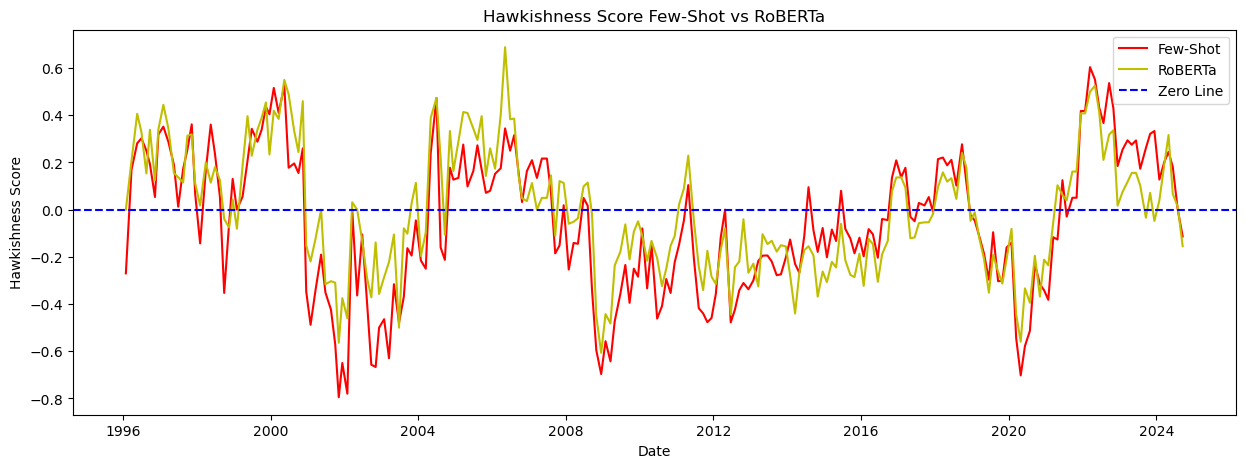

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(merged_hawkishness_data['Date'], merged_hawkishness_data['Hawkishness Score_few_shot'], label='Few-Shot', color='r')
plt.plot(merged_hawkishness_data['Date'], merged_hawkishness_data['Hawkishness Score_RoBERTa'], label='RoBERTa', color='y')
plt.axhline(y=0, color='b', linestyle='--', label='Zero Line')
plt.title('Hawkishness Score Few-Shot vs RoBERTa')
plt.xlabel('Date')
plt.ylabel('Hawkishness Score')
plt.legend()
plt.savefig("Hawkishness_Score_FewShot_vs_RoBERTa.svg", format="svg") 
plt.show()

In [680]:
# merged_hawkishness_data

#### Step 4: Market Analysis and Trading Strategy
---

In [452]:
msf = pd.read_csv('MSF_1996_2023.csv')
msf['date'] = pd.to_datetime(msf['date'], format = '%Y-%m-%d')
# msf['year'] = msf['date'].dt.year
msf['Month'] = pd.to_datetime(msf['date']).dt.to_period('M')
msf['SICCD'] = pd.to_numeric(msf['SICCD'], errors='coerce')
msf['RET'] = pd.to_numeric(msf['RET'], errors='coerce')
# msf['vwretd'] = pd.to_numeric(msf['vwretd'], errors='coerce')
msf['MarketCap'] = msf['PRC'] * msf['SHROUT']

def classify_industry(SICCD):
    if 1 <= SICCD <= 999:
        return 'Agriculture, Forestry and Fishing'
    elif 1000 <= SICCD <= 1499:
        return 'Mining'
    elif 1500 <= SICCD <= 1799:
        return 'Construction'
    elif 2000 <= SICCD <= 3999:
        return 'Manufacturing'
    elif 4000 <= SICCD <= 4999:
        return 'Transportation and other Utilities'
    elif 5000 <= SICCD <= 5199:
        return 'Wholesale Trade'
    elif 5200 <= SICCD <= 5999:
        return 'Retail Trade'
    elif 6000 <= SICCD <= 6799:
        return 'Finance, Insurance and Real Estate'
    elif 7000 <= SICCD <= 8999:
        return 'Services'
    elif 9000 <= SICCD <= 9999:
        return 'Public Administration'
    else:
        return 'Unknown'

msf['Industry'] = msf['SICCD'].apply(classify_industry)

msf = msf[msf['Industry'] != 'Unknown']



In [453]:
# First condition: Stocks must satisfy the going concern assumption, so I want to filter stocks that exist for the whole period
stocks = msf.groupby('PERMNO').size()   # Count the number of months for each stock
stocks = stocks[stocks == len(msf['Month'].unique())].index     
msf = msf[msf['PERMNO'].isin(stocks)]

# Second condition: Some stocks have PRC < 0, remove these stocks
invalid_stocks = msf[msf['PRC'] < 0]['PERMNO'].unique()
msf = msf[~msf['PERMNO'].isin(invalid_stocks)]

# Third condition: I donnot want to trade on stocks that have too small Market Cap
lower_quantile = msf['MarketCap'].quantile(0.05) 
msf = msf[msf['MarketCap'] >= lower_quantile] 

In [454]:
merged_msf_hawkish = pd.merge(msf, merged_hawkishness_data, on='Month', how='left')

In [197]:
# merged_msf_hawkish

In [2]:
# # hawkishness scores distribution
# plt.figure(figsize=(15, 5))
# sns.histplot(merged_msf_hawkish['Hawkishness Score_few_shot'], kde=True, color='blue', label='Few-Shot')
# plt.title('Hawkishness Score Distribution')
# plt.xlabel('Hawkishness Score')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()


**4.1 Define Your Stock Selection Criteria and Portfolio Composition**

**4.1.1 Stock Selection Criteria:**
 - Historical Performance: Stocks are chosen based on their rolling 12-month return, which captures their performance trend over the past year. This helps in selecting stocks that have demonstrated stability and potential growth, making them suitable for inclusion.
 - Sector Classification: Stocks are categorized by sector to align with macroeconomic conditions reflected in hawkishness scores. The strategy targets specific sectors expected to benefit or be harmed under different monetary policies.
 - Liquidity and Stability: Only stocks that satisfy the going concern assumption, exhibit a positive price (PRC) are considered. Additionally, stocks must have a market capitalization above a certain threshold to ensure sufficient liquidity and reduce the risk of volatile price movements.


**4.1.2 Portfolio Composition:**

**When hawkishness_scores > 0.2 (Hawkish Monetary Policy)**

- **Long Positions**: Focus on sectors that historically perform well during hawkish periods, which are:
  - Finance, Insurance, and Real Estate: Beneficiaries of higher interest rates which can boost profit margins.
  - Public Administration: Can remain stable due to government involvement and spending.
- Stock Selection: Choose up to 15 stocks in total across these sectors with the highest 12-month rolling return. These stocks should exhibit resilience or potential in the face of tightening monetary policy.

- **Short Positions**: Short stocks in sectors likely to perform poorly under hawkish policies, which are:
  - Construction: Heavily reliant on borrowing; higher rates increase financing costs.
  - Retail Trade: Consumer spending tends to decline with higher rates, reducing retail revenues.
- Stock Selection: As short stock is associated with more risk, I only short up to 5 stocks in total from these sectors with the lowest 12-month rolling return. These stocks are anticipated to underperform due to increased borrowing costs and reduced consumer spending.

**When hawkishness_scores < -0.2 (Dovish Monetary Policy)**

- **Long Positions**: Invest in sectors that tend to perform well under dovish policies, which are:
  - Construction: Lower interest rates reduce borrowing costs and boost project funding.
  - Retail Trade: Benefits from increased consumer spending and accessible credit.
- Stock Selection: For each of these sectors, select up to 15 stocks with the highest rolling 12-month return. These stocks are expected to benefit from a dovish monetary policy, which can stimulate consumer spending, borrowing, and investment.

- **Short Positions**: Short stocks in sectors that may not benefit as much from dovish policies, which are:
  - Finance, Insurance, and Real Estate: Potential margin compression due to lower interest rates.
  - Public Administration: Potential mixed effects depending on fiscal responses.
- Stock Selection: Short up to 5 stocks in total from these sectors with the lowest 12-month rolling return. These stocks are less likely to experience significant gains in a dovish environment.

**When hawkishness_scores are between -0.2 and 0.2 (Neutral Monetary Policy):**

- **Balanced Strategy:**
  - Long Positions: Choose up to 5 stocks from each of the all sectors based on the highest 12-month rolling return. This ensures a diversified approach that captures the best-performing stocks across all sectors.
  - Short Positions: Short up to 2 stocks from each of the all sectors with the lowest 12-month rolling return. This balances the strategy by hedging against potential underperformers.

**Key Point Considered**:
- **Portfolio Balance**: 
  - The strategy maintains a balanced approach by allocating equal weights to all long and short positions within the portfolio. This ensures that no single stock or sector dominates the portfolio, allowing for diversification and reduced idiosyncratic risk.
- **Hawkishness score lag impact is incorporated in Strategy**:
  - The use of rolling 12-month returns accounts for potential delayed impacts of monetary policy changes, ensuring that stock selection reflects both immediate and lagged market responses. This approach helps the strategy stay adaptable to evolving macroeconomic conditions.

**4.2 Implement the Strategy:**

**4.2.1 Portfolio Composition:**


In [ ]:
df = merged_msf_hawkish.copy()
df = df.sort_values(['PERMNO', 'Month']) 

harm_sectors = ['Construction', 'Retail Trade']
beneficial_sectors= ['Finance, Insurance and Real Estate', 'Public Administration']
all_sectors = ['Finance, Insurance and Real Estate', 'Public Administration', 'Agriculture, Forestry and Fishing', 'Construction', 'Retail Trade', 'Mining', 'Manufacturing', 'Transportation and other Utilities', 'Wholesale Trade', 'Services']

# calculate every stock's rolling 12 months return, current month is not included
df['rolling_RET'] = df.groupby('PERMNO')['RET'].transform(lambda x: x.rolling(12, closed='left').mean())

portfolio_returns = []
previous_long_positions = set()   # track
previous_short_positions = set()  # track

for month in df[df['Month'] >= '1997-01']['Month'].unique():    # nan in first 12m's rolling_RET, filter out
    month_data = df[df['Month'] == month].copy()
    
    # Does hawkish score exist in this month?
    hawkish_score = month_data['Hawkishness Score_few_shot'].iloc[0] if not month_data['Hawkishness Score_few_shot'].isna().all() else None
    
    if hawkish_score is not None:  # may trade when hawkish score exist
        long_stocks = []
        short_stocks = []
        
        if hawkish_score > 0.2:  # hawkish
            # Go long at most 10 stocks with the highest 12-month rolling return in beneficial sectors under hawkish
            for sector in beneficial_sectors:
                sector_stocks = month_data[month_data['Industry'] == sector]
                num_long_stocks = min(15, len(sector_stocks))
                long_candidates = sector_stocks.nlargest(num_long_stocks, 'rolling_RET')
                long_stocks.extend(long_candidates['PERMNO'].tolist())

            # Short at most 10 stocks with the lowest 12-month rolling return in harm sectors under hawkish
            for sector in harm_sectors:
                sector_stocks = month_data[month_data['Industry'] == sector]
                num_short_stocks = min(5, len(sector_stocks))
                short_candidates = sector_stocks.nsmallest(num_short_stocks, 'rolling_RET')     
                short_stocks.extend(short_candidates['PERMNO'].tolist())

        elif hawkish_score < - 0.2:  # Dovish
            # Go long at most 10 stocks with the highest 12-month rolling return in harm sectors under hawkish, which are actually beneficial under dovish
            for sector in harm_sectors:
                sector_stocks = month_data[month_data['Industry'] == sector]
                num_long_stocks = min(15, len(sector_stocks))
                long_candidates = sector_stocks.nlargest(num_long_stocks, 'rolling_RET')
                long_stocks.extend(long_candidates['PERMNO'].tolist())
            
            # Short at most 10 stocks with the lowest 12-month rolling return in beneficial sectors under hawkish, which actually perform poor under dovish
            for sector in beneficial_sectors:
                sector_stocks = month_data[month_data['Industry'] == sector]
                num_short_stocks = min(5, len(sector_stocks))
                short_candidates = sector_stocks.nsmallest(num_short_stocks, 'rolling_RET') 
                short_stocks.extend(short_candidates['PERMNO'].tolist())

        else: # hawkish_score neutral strategy
            for sector in all_sectors:
                sector_stocks = month_data[month_data['Industry'] == sector]
                num_long_stocks = min(5, len(sector_stocks))
                long_candidates = sector_stocks.nlargest(num_long_stocks, 'rolling_RET')
                long_stocks.extend(long_candidates['PERMNO'].tolist())

            for sector in all_sectors:
                sector_stocks = month_data[month_data['Industry'] == sector]
                num_short_stocks = min(2, len(sector_stocks))
                short_candidates = sector_stocks.nsmallest(num_short_stocks, 'rolling_RET')
                short_stocks.extend(short_candidates['PERMNO'].tolist())


        # Update previous long and short positions
        previous_long_positions = set(long_stocks)
        previous_short_positions = set(short_stocks)
        
        # Calculate the portfolio return for the month, with equal weight for each stock
        if long_stocks:
            long_returns = month_data[month_data['PERMNO'].isin(long_stocks)]['RET'].mean()
        else:
            long_returns = 0
            
        if short_stocks:
            short_returns = -month_data[month_data['PERMNO'].isin(short_stocks)]['RET'].mean()
        else:
            short_returns = 0
        
        # Calculate weighted portfolio return
        total_positions = len(long_stocks) + len(short_stocks)
        if total_positions > 0:
            portfolio_return = (long_returns * len(long_stocks) + short_returns * len(short_stocks)) / total_positions
        else:
            portfolio_return = 0

        
    else:  # If no hawkish score, maintain the previous positions
        if previous_long_positions or previous_short_positions:
            if previous_long_positions:
                long_returns = month_data[month_data['PERMNO'].isin(previous_long_positions)]['RET'].mean()
            else:
                long_returns = 0
                
            if previous_short_positions:
                short_returns = -month_data[month_data['PERMNO'].isin(previous_short_positions)]['RET'].mean()
            else:
                short_returns = 0
            
            # Calculate weighted portfolio return
            total_positions = len(previous_long_positions) + len(previous_short_positions)
            if total_positions > 0:
                portfolio_return = (long_returns * len(previous_long_positions) + short_returns * len(previous_short_positions)) / total_positions
            else:
                portfolio_return = 0
        else:
            portfolio_return = 0
    
    # print(f"Month: {month}")
    # print(f"  Hawkishness Score: {hawkish_score}")
    # print(f"  Long Positions: {long_stocks}")
    # print(f"  Long Returns: {long_returns}")
    # print(f"  Short Positions: {short_stocks}")
    # print(f"  Short Returns: {short_returns}")
    # print(f"  Portfolio Return: {portfolio_return}")

    portfolio_returns.append({
        'Month': month,
        'portfolio_return': portfolio_return
    })

# Calculate cumulative return and annualized volatility
portfolio_returns_df = pd.DataFrame(portfolio_returns)
portfolio_returns_df['cumulative_return'] = (1 + portfolio_returns_df['portfolio_return']).cumprod() - 1
portfolio_returns_df['annualized_volatility'] = portfolio_returns_df['portfolio_return'].rolling(12).std() * np.sqrt(12)   # 12-month rolling annualized volatility

In [456]:
print('Portfolio Performance:') 
portfolio_returns_df

Portfolio Performance:


,Month,portfolio_return,cumulative_return,annualized_volatility
0,1997-01,0.000000,0.000000,NaN
1,1997-02,0.002367,0.002367,NaN
2,1997-03,-0.054751,-0.052514,NaN
3,1997-04,0.025373,-0.028473,NaN
4,1997-05,0.038331,0.008767,NaN
...,...,...,...,...
319,2023-08,0.012269,11.336350,0.108923
320,2023-09,0.005114,11.399440,0.100464
321,2023-10,-0.027235,11.061737,0.098531
322,2023-11,0.024986,11.363106,0.092720


In [ ]:
# # Add USREC data
# NBER_df = pdr.get_data_fred('USREC', start='1996-01-01', end='2023-12-29')
# NBER_df.reset_index(inplace=True)
# NBER_df.columns = ['Date', 'NBER']
# NBER_df['Month'] = pd.to_datetime(NBER_df['Date']).dt.to_period('M')
# NBER_df = NBER_df[(NBER_df['Month'] >= '1996-01') & (NBER_df['Month'] <= '2024-10')]
# NBER_df = NBER_df.drop(['Date'], axis = 1)

# portfolio_returns_df_with_NBER = pd.merge(portfolio_returns_df, NBER_df, on='Month', how='left')

In [300]:
# portfolio_returns_df_with_NBER

In [377]:
import yfinance as yf
sp500 = yf.download('^GSPC', start='1996-12-28', end='2023-12-29')  # daily data
sp500 = sp500.reset_index()
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500['Month'] = sp500['Date'].dt.to_period('M')
sp500 = sp500.groupby('Month').apply(lambda x: x.iloc[-1])  # Monthly data
sp500['sp500_monthly_return'] = sp500['Adj Close'].pct_change()
sp500['sp500_cumulative_return'] = (1 + sp500['sp500_monthly_return']).cumprod() - 1
sp500.reset_index(drop=True, inplace=True)


[*********************100%***********************]  1 of 1 completed


In [378]:
sp500_return_df = sp500.iloc[1:]
sp500_return_df.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Month', 'sp500_monthly_return', 'sp500_cumulative_return']
sp500_return_df = sp500_return_df.drop(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], axis = 1)
sp500_return_df['sp500_annualized_vol'] = sp500_return_df['sp500_monthly_return'].rolling(12).std() * np.sqrt(12)

In [373]:
# sp500_return_df

In [457]:
merged_returns = pd.merge(portfolio_returns_df, sp500_return_df, on='Month', how='left')
# merged_returns['Month'] = pd.to_datetime(merged_returns['Month'].dt.to_timestamp())

In [458]:
mkt_return = msf.groupby('Month')['vwretd'].apply(lambda x: x.iloc[0] if isinstance(x.iloc[0], list) and len(x.iloc[0]) > 0 else x.iloc[0]).reset_index()

merged_returns = pd.merge(merged_returns, mkt_return, on='Month', how='left')
merged_returns['mkt_cumulative_return'] = (1 + merged_returns['vwretd']).cumprod() - 1
merged_returns['mkt_annualized_vol'] = merged_returns['vwretd'].rolling(12).std() * np.sqrt(12)

In [423]:
# merged_returns

In [459]:
merged_returns_with_hawkishness = pd.merge(merged_returns, few_shot_hawkishness_data, on='Month', how='left')
merged_returns_with_hawkishness['Hawkishness Score'].fillna(method='ffill', inplace=True)

In [265]:
# merged_returns_with_hawkishness

**4.2.2 Plot it along with cumulative market return for better comparison**

**Discussion:**

- Portfolio Outperformance: The portfolio significantly outpaces both the S&P 500 and the general market, showcasing the effectiveness of its stock selection and sector allocation strategy.

- Comparison Highlights:
  - S&P 500: The portfolio's superior cumulative return indicates better risk-adjusted performance and strategic positioning.
  - Market: The portfolio's targeted approach results in higher returns compared to the broader market, leveraging sector strengths under different monetary policies.

- Resilience: The portfolio's consistent growth underscores its robustness and adaptability in varied market conditions.

In [354]:
# merged_returns_with_hawkishness

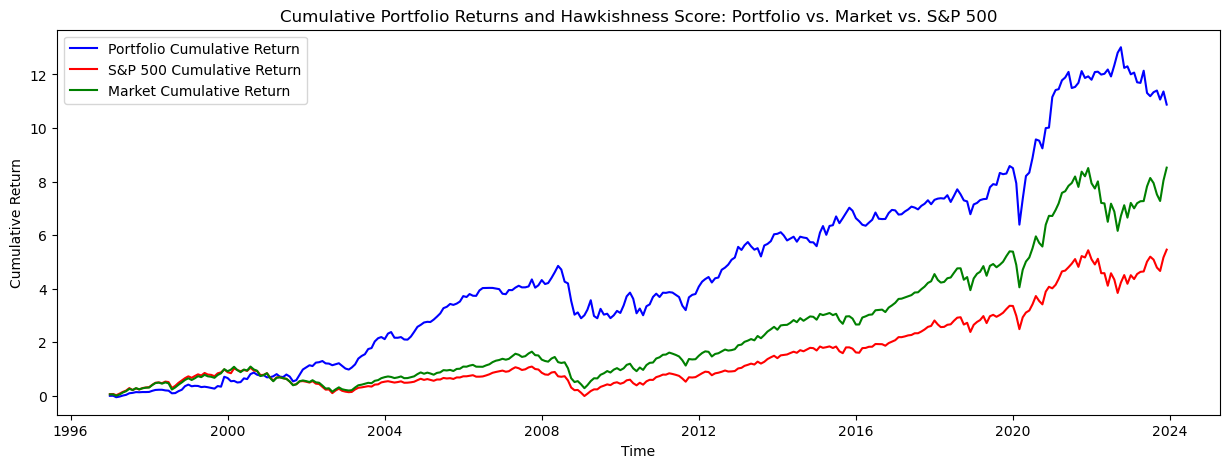

In [460]:
# plot cumulative returns with hawkishness
merged_returns_with_hawkishness['Month'] = pd.to_datetime(merged_returns_with_hawkishness['Month'].dt.to_timestamp())
# left y-axis (showing cumulative returns)
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot cumulative_return and sp500_cumulative_return
ax1.plot(merged_returns_with_hawkishness['Month'], merged_returns_with_hawkishness['cumulative_return'], label='Portfolio Cumulative Return', color='b')
ax1.plot(merged_returns_with_hawkishness['Month'], merged_returns_with_hawkishness['sp500_cumulative_return'], label='S&P 500 Cumulative Return', color='r')
ax1.plot(merged_returns_with_hawkishness['Month'], merged_returns_with_hawkishness['mkt_cumulative_return'], label='Market Cumulative Return', color='g')
ax1.set_xlabel('Time')
ax1.set_ylabel('Cumulative Return')
# ax1.set_yscale('log')   # Use log scale for better handling of large data differences

# # Add volatility to the left y-axis
# ax1.plot(merged_returns_with_hawkishness['Month'], merged_returns_with_hawkishness['annualized_volatility'], label='Portfolio Annualized Volatility', color='b', linestyle='--', alpha=0.7)
# ax1.plot(merged_returns_with_hawkishness['Month'], merged_returns_with_hawkishness['sp500_annualized_vol'], label='S&P 500 Annualized Volatility', color='r', linestyle='--', alpha=0.7)

ax1.legend(loc='upper left')

# ax2 = ax1.twinx()
# ax2.set_ylabel('Few-Shot Hawkishness Score')
# ax2.plot(merged_returns_with_hawkishness['Month'], merged_returns_with_hawkishness['Hawkishness Score'], label='Few-Shot Hawkishness Score', color='y', linestyle='--')

# ax2.legend(loc='upper right')

plt.title('Cumulative Portfolio Returns and Hawkishness Score: Portfolio vs. Market vs. S&P 500')
plt.savefig("Cumulative_Returns_Portfolio_vs_SP500.svg", format="svg")  # Save as SVG
plt.show()

In [461]:
import pandas_datareader as pdr
from datetime import datetime

# Define the start and end dates
start_date = datetime(1996, 1, 1)
end_date = datetime(2023, 12, 31)

# Fetch FRED data using pandas_datareader
rf = pdr.get_data_fred('DGS10', start=start_date, end=end_date)

# Reset index for better handling
rf.reset_index(inplace=True)

# Rename columns for clarity
rf.columns = ['Date_rf', 'rf']

# Create Month column
rf['Month'] = pd.to_datetime(rf['Date_rf']).dt.to_period('M')

rf = rf.dropna()

# Get the last rf value for each month
monthly_rf = rf.groupby('Month').apply(lambda x: x.iloc[-1]).reset_index(drop=True)
monthly_rf['rf'] = monthly_rf['rf'] * 0.01

In [195]:
# merged_returns_with_hawkishness

In [462]:
# merged_returns_with_hawkishness['Month'] = merged_returns_with_hawkishness['Month'].dt.to_period('M')
merged_returns_with_hawkishness['Month'] = pd.to_datetime(merged_returns_with_hawkishness['Month'], errors='coerce')

merged_returns_with_hawkishness['Month'] = merged_returns_with_hawkishness['Month'].dt.to_period('M')

merged_returns_with_hawkishness_rf = pd.merge(merged_returns_with_hawkishness, monthly_rf, on='Month', how='left')

In [196]:
# merged_returns_with_hawkishness_rf


**4.2.2 Comparing cumulative returns under different monetary policy stances**

In [463]:
# Cumulative returns for hawkish periods
hawkish_policy_data = merged_returns_with_hawkishness_rf[merged_returns_with_hawkishness_rf['Hawkishness Score'] > 0]
hawkish_policy_data['cumulative_return'] = (1 + hawkish_policy_data['portfolio_return']).cumprod() - 1
hawkish_policy_cumulative_return = hawkish_policy_data['cumulative_return'].iloc[-1]  # Get the last cumulative return value

# Cumulative returns for dovish periods
dovish_policy_data = merged_returns_with_hawkishness_rf[merged_returns_with_hawkishness_rf['Hawkishness Score'] < 0]
dovish_policy_data['cumulative_return'] = (1 + dovish_policy_data['portfolio_return']).cumprod() - 1
dovish_policy_cumulative_return = dovish_policy_data['cumulative_return'].iloc[-1]  # Get the last cumulative return value

print(f"Portfolio cumulative return for hawkish policy stances: {hawkish_policy_cumulative_return}")
print(f"Portfolio cumulative return for dovish policy stances: {dovish_policy_cumulative_return}")

Portfolio cumulative return for hawkish policy stances: 1.3026868431956165
Portfolio cumulative return for dovish policy stances: 4.286796767416858


In [464]:
# Calculate the number of months in hawkish and dovish periods
hawkish_policy_data = merged_returns_with_hawkishness_rf[merged_returns_with_hawkishness_rf['Hawkishness Score'] > 0]
dovish_policy_data = merged_returns_with_hawkishness_rf[merged_returns_with_hawkishness_rf['Hawkishness Score'] < 0]

# Calculate average monthly return for hawkish and dovish periods
average_monthly_return_hawkish = hawkish_policy_data['portfolio_return'].mean()
average_monthly_return_dovish = dovish_policy_data['portfolio_return'].mean()

# Calculate annualized return for hawkish and dovish periods
annualized_return_hawkish = ((1 + average_monthly_return_hawkish) ** 12) - 1
annualized_return_dovish = ((1 + average_monthly_return_dovish) ** 12) - 1

# Print the results
print(f"Average monthly return for hawkish policy stances: {average_monthly_return_hawkish:.4f}")
print(f"Annualized return for hawkish policy stances: {annualized_return_hawkish:.4f}")

print(f"Average monthly return for dovish policy stances: {average_monthly_return_dovish:.4f}")
print(f"Annualized return for dovish policy stances: {annualized_return_dovish:.4f}")

Average monthly return for hawkish policy stances: 0.0067
Annualized return for hawkish policy stances: 0.0839
Average monthly return for dovish policy stances: 0.0104
Annualized return for dovish policy stances: 0.1324


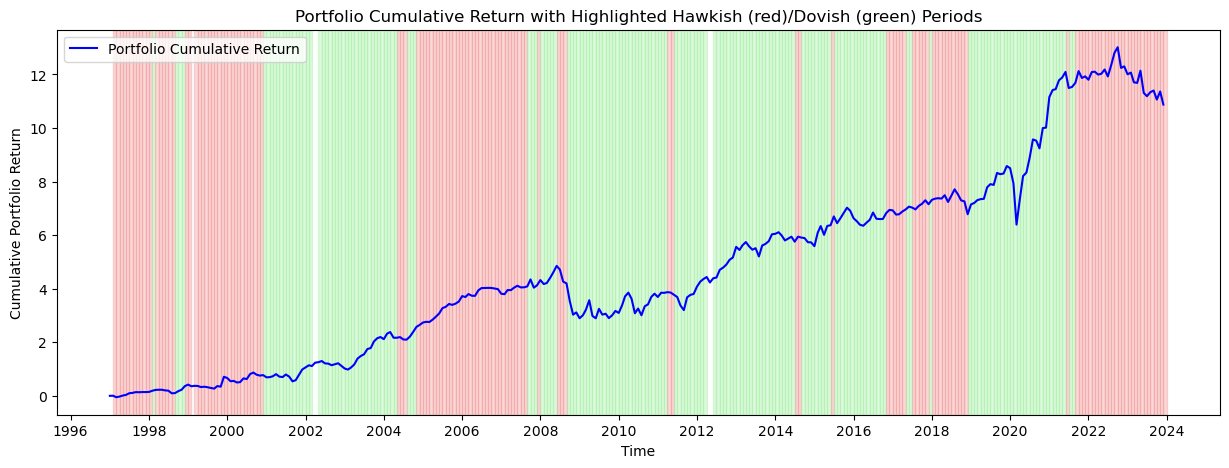

In [465]:
import matplotlib.dates as mdates

# Ensure the Month column is in datetime format for plotting
merged_returns_with_hawkishness_rf['Month'] = merged_returns_with_hawkishness_rf['Month'].dt.to_timestamp()

# Create a plot
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the cumulative portfolio return
ax.plot(merged_returns_with_hawkishness_rf['Month'], merged_returns_with_hawkishness_rf['cumulative_return'], color='blue', label='Portfolio Cumulative Return')

# Highlight periods with positive and negative Hawkishness Scores
for i in range(len(merged_returns_with_hawkishness_rf)):
    if merged_returns_with_hawkishness_rf['Hawkishness Score'].iloc[i] > 0:
        ax.axvspan(merged_returns_with_hawkishness_rf['Month'].iloc[i], 
                   merged_returns_with_hawkishness_rf['Month'].iloc[i] + pd.DateOffset(months=1), 
                   color='lightcoral', alpha=0.3)
    elif merged_returns_with_hawkishness_rf['Hawkishness Score'].iloc[i] < 0:
        ax.axvspan(merged_returns_with_hawkishness_rf['Month'].iloc[i], 
                   merged_returns_with_hawkishness_rf['Month'].iloc[i] + pd.DateOffset(months=1), 
                   color='lightgreen', alpha=0.3)

# Format the x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Cumulative Portfolio Return')
plt.title('Portfolio Cumulative Return with Highlighted Hawkish (red)/Dovish (green) Periods')
plt.legend(loc='upper left')

# Show the plot
plt.savefig("Cumulative_Portfolio_Returns_with_Highlighted_Policy_Periods.svg", format="svg")  # Save as SVG
plt.show()

**4.2.2 Comparison metrics: sharpe ratio, Sortino ratio, max drawdown**

**Discussion:**

- Sharpe Ratio: 
  - The portfolio's Sharpe Ratio of 0.6582 is notably higher than the S&P 500's 0.4944 and the market's 0.5734 (from msf data). This demonstrates the portfolio's superior risk-adjusted return, showcasing effective risk management and selection strategies that outperform both the broader market and S&P 500.
- Sortino Ratio: 
  - With a Sortino Ratio of 0.9623, the portfolio outperforms the S&P 500's 0.6820 and the market's 0.8169. This indicates the portfolio's strong ability to generate returns while minimizing downside risk, appealing to investors who prioritize protection against negative market movements.
- Max Drawdown: 
  - The portfolio's maximum drawdown of -33.43% is significantly less severe compared to the S&P 500's -52.56% and the market's -51.48%. This reflects the portfolio's effective risk management strategy in mitigating significant losses, providing better resilience during downturns.

In [466]:
# Calculate excess returns
merged_returns_with_hawkishness_rf['excess_portfolio_return'] = merged_returns_with_hawkishness_rf['portfolio_return'] - merged_returns_with_hawkishness_rf['rf'] / 100
merged_returns_with_hawkishness_rf['excess_sp500_return'] = merged_returns_with_hawkishness_rf['sp500_monthly_return'] - merged_returns_with_hawkishness_rf['rf'] / 100
merged_returns_with_hawkishness_rf['excess_mkt_return'] = merged_returns_with_hawkishness_rf['vwretd'] - merged_returns_with_hawkishness_rf['rf'] / 100

# Calculate Sharpe Ratio
sharpe_ratio_portfolio = merged_returns_with_hawkishness_rf['excess_portfolio_return'].mean() / merged_returns_with_hawkishness_rf['excess_portfolio_return'].std() * np.sqrt(12)
sharpe_ratio_sp500 = merged_returns_with_hawkishness_rf['excess_sp500_return'].mean() / merged_returns_with_hawkishness_rf['excess_sp500_return'].std() * np.sqrt(12)
sharpe_ratio_mkt = merged_returns_with_hawkishness_rf['excess_mkt_return'].mean() / merged_returns_with_hawkishness_rf['excess_mkt_return'].std() * np.sqrt(12)

# Calculate Sortino Ratio
downside_deviation_portfolio = merged_returns_with_hawkishness_rf.loc[merged_returns_with_hawkishness_rf['excess_portfolio_return'] < 0, 'excess_portfolio_return'].std()
sortino_ratio_portfolio = merged_returns_with_hawkishness_rf['excess_portfolio_return'].mean() / downside_deviation_portfolio * np.sqrt(12)

downside_deviation_sp500 = merged_returns_with_hawkishness_rf.loc[merged_returns_with_hawkishness_rf['excess_sp500_return'] < 0, 'excess_sp500_return'].std()
sortino_ratio_sp500 = merged_returns_with_hawkishness_rf['excess_sp500_return'].mean() / downside_deviation_sp500 * np.sqrt(12)

downside_deviation_mkt = merged_returns_with_hawkishness_rf.loc[merged_returns_with_hawkishness_rf['excess_mkt_return'] < 0, 'excess_sp500_return'].std()
sortino_ratio_mkt = merged_returns_with_hawkishness_rf['excess_mkt_return'].mean() / downside_deviation_mkt * np.sqrt(12)

# Calculate Max Drawdown for Portfolio
cumulative_return_portfolio = (1 + merged_returns_with_hawkishness_rf['portfolio_return']).cumprod()
drawdown_portfolio = cumulative_return_portfolio / cumulative_return_portfolio.cummax() - 1
max_drawdown_portfolio = drawdown_portfolio.min()

# Calculate Max Drawdown for S&P 500
cumulative_return_sp500 = (1 + merged_returns_with_hawkishness_rf['sp500_monthly_return']).cumprod()
drawdown_sp500 = cumulative_return_sp500 / cumulative_return_sp500.cummax() - 1
max_drawdown_sp500 = drawdown_sp500.min()

# Calculate Max Drawdown for Market from msf data
cumulative_return_mkt = (1 + merged_returns_with_hawkishness_rf['vwretd']).cumprod()
drawdown_mkt = cumulative_return_mkt / cumulative_return_mkt.cummax() - 1
max_drawdown_mkt = drawdown_mkt.min()

# Print results
print("Portfolio Metrics:")
print(f"Sharpe Ratio: {sharpe_ratio_portfolio:.4f}")
print(f"Sortino Ratio: {sortino_ratio_portfolio:.4f}")
print(f"Max Drawdown: {max_drawdown_portfolio:.4%}")

print("\nS&P 500 Metrics:")
print(f"Sharpe Ratio: {sharpe_ratio_sp500:.4f}")
print(f"Sortino Ratio: {sortino_ratio_sp500:.4f}")
print(f"Max Drawdown: {max_drawdown_sp500:.4%}")

print("\nMarket Metrics from msf data:")
print(f"Sharpe Ratio: {sharpe_ratio_mkt:.4f}")
print(f"Sortino Ratio: {sortino_ratio_mkt:.4f}")
print(f"Max Drawdown: {max_drawdown_mkt:.4%}")

Portfolio Metrics:
Sharpe Ratio: 0.6582
Sortino Ratio: 0.9623
Max Drawdown: -33.4270%

S&P 500 Metrics:
Sharpe Ratio: 0.4944
Sortino Ratio: 0.6820
Max Drawdown: -52.5559%

Market Metrics from msf data:
Sharpe Ratio: 0.5734
Sortino Ratio: 0.8169
Max Drawdown: -51.4774%


**4.3 Insights**

**4.3.1 Summarize insights from comparing cumulative returns under different monetary policy stances.**

**Hawkish Policy Stance Analysis:**

- Cumulative Return: The portfolio's cumulative return during hawkish policy stances is approximately 1.30, indicating modest gains during these periods.
- Average Monthly Return: The average monthly return during hawkish periods is 0.67%, translating to an annualized return of 8.39%.
- Observations:
    - The cumulative return and annualized return indicate that the portfolio has a moderate capability to capture gains during hawkish policy periods. This could suggest strategic allocation towards industries and stocks that perform relatively well under tightening monetary conditions.
    - The performance highlights a portfolio that, while still not as robust as during dovish periods, shows resilience and positive gains during hawkish stances.

**Dovish Policy Stance Analysis:**

- Cumulative Return: The portfolio's cumulative return during dovish policy stances is higher, at approximately 4.29, showing significant outperformance compared to hawkish periods.
- Average Monthly Return: The average monthly return during dovish periods is 1.04%, leading to an annualized return of 13.24%.
- Observations:
    - The consistent outperformance during dovish periods indicates that the portfolio is likely weighted towards growth-oriented or cyclical sectors that thrive in a low-interest-rate environment.
    - This implies an effective capture of economic growth opportunities, benefiting from higher market liquidity and investor risk appetite typical of dovish periods.

**Overall Insights:**
- Robust Performance: The portfolio's ability to generate positive returns under both hawkish and dovish stances shows its versatility. However, the stronger results during dovish periods suggest an investment strategy that may favor sectors sensitive to growth and lower borrowing costs.
- Outperformance During Dovish Periods: The significant cumulative return and higher annualized return during dovish periods indicate a strategic focus on investments that leverage favorable economic conditions, including industries like Construction and Retail Trade.

**4.3.2 Reflect on the reliability of using LLM-based classification for financial forecasting.**

**Strengths:**

- Zero-shot and Few-shot Capability: As shown in this FOMC Hawkishness prediction task, LLMs can perform well even with minimal to no task-specific training (zero-shot or few-shot inference). This is particularly useful when labeled data is scarce or difficult to obtain, making it possible to classify financial sentiments or forecast trends based on prompts alone.
- Adaptability: LLMs can understand and classify complex financial language without needing extensive training data, making them adaptable to many financial NLP tasks.

**Limitations:**

- Limited Access: High-quality LLMs may require significant resources or subscriptions, limiting access for smaller institutions or individual users.
- Domain-specific Limitations: LLMs may not match the accuracy of models trained specifically on financial data, leading to less reliable results in specialized tasks.
- Lack of Transparency: The decision-making process of LLMs can be difficult to interpret, which reduces trust, especially in financial forecasting where explainability is critical.
- Inference Time: The latency of generating outputs with LLMs, especially larger models, can be significant. This can hinder their practical application in real-time financial forecasting where rapid decision-making is crucial.

**Conclusion:**

While LLM-based classification has the potential to be a powerful tool for financial forecasting, its reliability depends on the context of use. LLMs offer great flexibility with good inferencing performance, especially in the few-shot scenario, but come with limitations related to domain specificity, interpretability, and real-time performance.